In [ ]:
# convert coco to aimmo
import os
import json
import numpy as np
from tqdm import tqdm

parent_path = "/data/noah/dataset/coco/pre_images"
out_annotation_path = "/data/noah/dataset/coco/pre_anno"
annotation_path = "/data/noah/dataset/coco/instances_train2017.json"

with open(annotation_path, "r") as f:
    annotation = json.load(f)

# print(annotation)

target_class = ["person"]  # bicycle #motorcycle
target_ids = []
for target in target_class:
    for cat in annotation["categories"]:
        if cat["name"] == target:
            target_ids.append(cat["id"])

assert len(target_class) == len(target_ids), "target_class must have same length with target_ids"

annotation_infos = annotation["annotations"]

for image_info in tqdm(annotation["images"]):
    image_name = image_info["file_name"]
    height, width = image_info["height"], image_info["width"]
    image_id = image_info["id"]

    aimmo_format = {
        "annotations": [],
        "attributes": {},
        "filename": image_name,
        "parent_path": parent_path,
        "metadata": {"height": height, "width": width},
    }

    annotations = []
    for idx, ann in enumerate(annotation_infos):
        if ann["image_id"] == image_id:
            for idx, target_id in enumerate(target_ids):
                if ann["category_id"] == target_id:
                    points = ann["segmentation"]

                    if isinstance(points, dict):
                        continue
                    else:
                        polygon_points = np.array(points[0]).reshape(-1, 2).astype(np.int32).tolist()

                    ann = {
                        "id": "",
                        "type": "poly_seg",
                        "attributes": {},
                        "points": polygon_points,
                        "label": target_class[idx],
                    }
                    annotations.append(ann)

    if len(annotations):
        aimmo_format["annotations"] = annotations
        path = os.path.join(out_annotation_path, "{}.json".format(image_name))
        with open(path, "w") as f:
            json.dump(aimmo_format, f)

In [ ]:
# Format {"image": "", "conditioning_images": "", "text": "", "annotation": ""}

# annotation -> mask -> condition image 생성
# prompt
import json
import os
import cv2
from PIL import Image
import numpy as np
import random

import cv2
import os
import csv
import json
import shutil
import numpy as np
from tqdm import tqdm
import torch
from PIL import Image
from controlnet_aux.processor import Processor
from diffusers.blip.models.blip import blip_decoder
from torchvision import transforms
from torchvision.transforms.functional import InterpolationMode

device = "cuda:3"
torch.cuda.set_device(device)


def load_demo_image(image, image_size, device):
    raw_image = image

    w, h = raw_image.size
    # display(raw_image.resize((w//5,h//5)))

    transform = transforms.Compose(
        [
            transforms.Resize((image_size, image_size), interpolation=InterpolationMode.BICUBIC),
            transforms.ToTensor(),
            transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711)),
        ]
    )
    image = transform(raw_image).unsqueeze(0).to(device)
    return image


annotation_path = "/data/noah/dataset/coco/anno"
condition_path = "/data/noah/dataset/coco/condition_images"
caption_path = os.path.join("/data/noah/dataset/coco", "train.jsonl")
gt_caption_path = "/data/noah/dataset/coco/tmp/captions_train2017.json"
target_classes = ["person"]

data = []

with open(gt_caption_path, "r") as f:
    gt_ann = json.load(f)

for annotation_name in tqdm(os.listdir(annotation_path)):
    anno_path = os.path.join(annotation_path, annotation_name)
    with open(anno_path, "r") as f:
        annotation = json.load(f)

    for img_info in gt_ann["images"]:
        if img_info["file_name"] == annotation["filename"]:
            image_id = img_info["id"]
            break

    captions = []
    for cap_info in gt_ann["annotations"]:
        if cap_info["image_id"] == cap_info["image_id"]:
            captions.append(cap_info["caption"])

    caption = ""
    for idx, cap in enumerate(captions):
        if idx == len(captions) - 1:
            caption += "{}".format(cap)
        else:
            caption += "{}, ".format(cap)

    # image_path
    image_path = os.path.join(annotation["parent_path"], annotation["filename"])
    con_path = os.path.join(condition_path, annotation["filename"])

    height, width = annotation["metadata"]["height"], annotation["metadata"]["width"]

    # generate condition image
    mask = np.zeros((height, width, 3))
    for ann in annotation["annotations"]:
        if ann["label"] in target_classes:
            pallete = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
            points = np.array(ann["points"], dtype=np.int32)
            try:
                mask = cv2.fillPoly(mask, [points], color=pallete)
            except:
                continue
    mask = Image.fromarray(mask.astype("uint8"))
    mask.save(con_path)
    # display(Image.fromarray(mask))
    # print(image_path)

    data.append(
        {
            "text": caption,
            "image": "images/{}".format(annotation["filename"]),
            "conditioning_images": "conditioning_images/{}".format(annotation["filename"]),
            "annotation": "anno/{}".format(annotation_name),
        }
    )

with open(caption_path, encoding="utf-8", mode="w") as f:
    for i in data:
        f.write(json.dumps(i) + "\n")

In [ ]:
# import os
# import pandas as pd
# import numpy as np
# from PIL import Image
# import matplotlib.pyplot as plt
# import io
# from tqdm import tqdm

# path = "/data/noah/dataset/coco/data"
# image_path = "/data/noah/dataset/coco/images"
# text_path = "/data/noah/dataset/coco/text"

# for _ in tqdm(os.listdir(path)):
#     n_path = os.path.join(path, _)

#     data = pd.read_parquet(n_path)

#     # print(data.keys())
#     # print(data["image"][0].keys())

#     # image = Image.open(io.BytesIO(data["image"][0]['bytes']))
#     # display(image)

#     for index, row in data.iterrows():
#         # print(row["sentences_raw"])
#         filename = row["filename"]
#         image_bytes = row["image"]["bytes"]
#         image = Image.open(io.BytesIO(image_bytes))
#         image.save(os.path.join(image_path, filename))

In [ ]:
# import os, sys

# sys.path.append(os.path.join(os.getcwd(), "GroundingDINO"))

# from IPython.display import display
# from PIL import Image, ImageDraw, ImageFont
# from torchvision.ops import box_convert

# # Grounding DINO
# import groundingdino.datasets.transforms as T
# from groundingdino.models import build_model
# from groundingdino.util import box_ops
# from groundingdino.util.slconfig import SLConfig
# from groundingdino.util.utils import clean_state_dict, get_phrases_from_posmap
# from groundingdino.util.inference import annotate, load_image, predict

# import supervision as sv

# # segment anything
# from segment_anything import build_sam, SamPredictor

# import cv2
# import numpy as np
# import matplotlib.pyplot as plt
# import PIL
# import torch
# import json

# from tqdm import tqdm


# def load_model(model_config_path, model_checkpoint_path, device):
#     args = SLConfig.fromfile(model_config_path)
#     args.device = device
#     model = build_model(args)
#     checkpoint = torch.load(model_checkpoint_path, map_location="cpu")
#     load_res = model.load_state_dict(clean_state_dict(checkpoint["model"]), strict=False)
#     print(load_res)
#     _ = model.eval()
#     return model


# # detect object using grounding DINO
# def detect(image, image_source, text_prompt, model, box_threshold=0.75, text_threshold=0.5):
#     boxes, logits, phrases = predict(
#         model=model, image=image, caption=text_prompt, box_threshold=box_threshold, text_threshold=text_threshold
#     )

#     annotated_frame = annotate(image_source=image_source, boxes=boxes, logits=logits, phrases=phrases)
#     annotated_frame = annotated_frame[..., ::-1]  # BGR to RGB
#     return annotated_frame, boxes


# def segment(image, sam_model, boxes):
#     sam_model.set_image(image)
#     H, W, _ = image.shape
#     boxes_xyxy = box_ops.box_cxcywh_to_xyxy(boxes) * torch.Tensor([W, H, W, H])

#     transformed_boxes = sam_model.transform.apply_boxes_torch(boxes_xyxy.to(device), image.shape[:2])
#     masks, _, _ = sam_model.predict_torch(
#         point_coords=None,
#         point_labels=None,
#         boxes=transformed_boxes,
#         multimask_output=False,
#     )
#     return masks.cpu()


# def draw_mask(mask, image, random_color=True):
#     if random_color:
#         color = np.concatenate([np.random.random(3), np.array([0.8])], axis=0)
#     else:
#         color = np.array([30 / 255, 144 / 255, 255 / 255, 0.6])
#     h, w = mask.shape[-2:]
#     mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)

#     annotated_frame_pil = Image.fromarray(image).convert("RGBA")
#     mask_image_pil = Image.fromarray((mask_image.cpu().numpy() * 255).astype(np.uint8)).convert("RGBA")

#     return np.array(Image.alpha_composite(annotated_frame_pil, mask_image_pil))


# # def mask_to_polygon(mask):
# #     # 윤곽선 찾기
# #     contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# #     # 윤곽선을 다각형으로 변환
# #     print(contours)
# #     polygons = []
# #     for contour in contours:
# #         polygon = contour.tolist()
# #         print(polygon)
# #         polygons.append(polygon)


# #     return polygons
# def mask_to_polygon(mask):
#     # 윤곽선 찾기
#     contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

#     # 윤곽선을 다각형으로 변환
#     polygons = []
#     for contour in contours:
#         contour = contour.squeeze(axis=1)  # 차원 축소
#         polygon = contour[:, [0, 1]].tolist()  # (y, x) 순서로 변환하여 리스트로 저장
#         polygons.append(polygon)

#     return polygons


# def polygon_to_mask(polygons, height, width):
#     # 빈 마스크 생성
#     mask = np.zeros((height, width), dtype=np.uint8)
#     polygons = np.array(polygons, dtype=np.int32)
#     mask = cv2.fillPoly(mask, [polygons], 255)

#     return mask


# device = torch.device("cuda:3")
# torch.cuda.set_device(device)

# grounding_dino_ckpt_path = "/data/noah/ckpt/pretrain_ckpt/Grounding_DINO/groundingdino_swinb_cogcoor.pth"
# grounding_dino_config_path = (
#     "/workspace/Grounded-Segment-Anything/GroundingDINO/groundingdino/config/GroundingDINO_SwinB.py"
# )
# grounding_dino = load_model(grounding_dino_config_path, grounding_dino_ckpt_path, device=device)

# sam_ckpt_path = "/data/noah/ckpt/pretrain_ckpt/SAM/sam_vit_h_4b8939.pth"
# sam_predictor = SamPredictor(build_sam(checkpoint=sam_ckpt_path).to(device))

# image_path = "/data/noah/dataset/coco/pre_images"
# anno_path = "/data/noah/dataset/coco/pre_anno"

# for image_name in tqdm(os.listdir(image_path)):
#     img_path = os.path.join(image_path, image_name)
#     image_source_np, image_torch = load_image(img_path)

#     # print(type(image_source))
#     # print(type(image))
#     height, width = image_source_np.shape[0], image_source_np.shape[1]

#     anno_file_path = os.path.join(anno_path, image_name[:-4] + ".json")
#     anno = {
#         "annotations": [],
#         "attributes": {},
#         "filename": image_name,
#         "parent_path": image_path,
#         "metadata": {"height": height, "width": width},
#     }

#     annotated_frame, detected_boxes = detect(image_torch, image_source_np, text_prompt="person", model=grounding_dino)

#     if len(detected_boxes) == 0:
#         continue

#     seg_result = segment(image_source_np, sam_predictor, boxes=detected_boxes)

#     for seg_map in seg_result:
#         annotation = {"id": "", "type": "poly_seg", "attributes": {}, "points": [], "label": "person"}

#         mask = seg_map[0].cpu().numpy().astype(np.uint8) * 255
#         # display(Image.fromarray(mask))

#         polygons = mask_to_polygon(mask)[0]
#         # print(polygons)

#         # mask = polygon_to_mask(polygons, 1024, 1920)
#         # display(Image.fromarray(mask))

#         annotation["points"] = polygons
#         anno["annotations"].append(annotation)

#     with open(anno_file_path, "w") as f:
#         json.dump(anno, f)

100%|██████████| 64115/64115 [09:49<00:00, 108.70it/s]


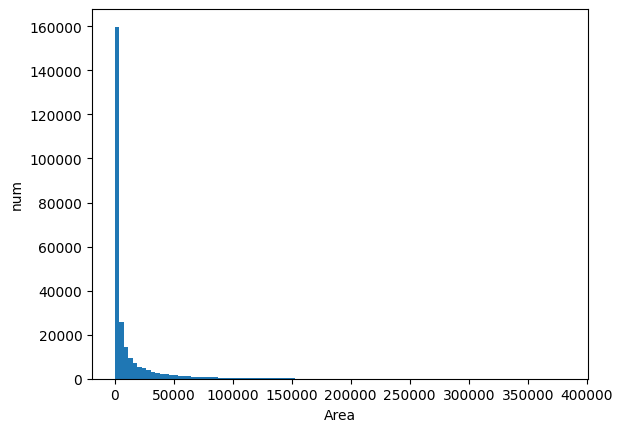

min_area : 10884.668656925283


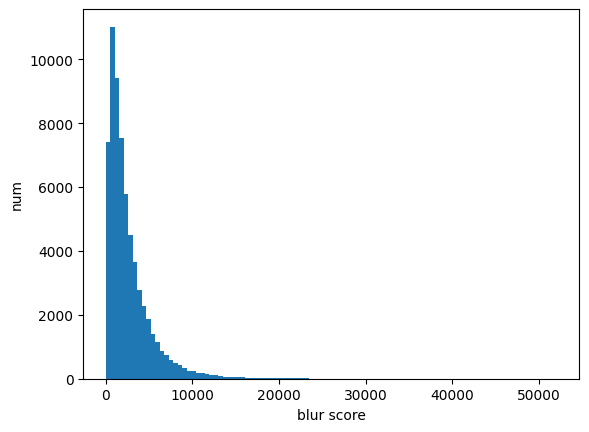

min_blur : 2658.5192832939783


In [13]:
import os
import json
import numpy as np
import cv2
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt


def estimate_blur(image):
    # Convert image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Compute Laplacian variance (a measure of sharpness)
    laplacian_var = cv2.Laplacian(gray, cv2.CV_64F).var()
    return laplacian_var


anno_path = "/data/noah/dataset/coco/pre_anno"
image_path = "/data/noah/dataset/coco/pre_images"
out_anno_path = "/data/noah/dataset/coco/anno"
out_image_path = "/data/noah/dataset/coco/images"

sizes = []
blur_scores = []
class_name = "person"

for anno_name in tqdm(os.listdir(anno_path)[:]):
    path = os.path.join(anno_path, anno_name)
    with open(path, "r") as f:
        anno = json.load(f)
    f.close()

    # image = cv2.imread(os.path.join(image_path, anno["parent_path"][1:], anno["filename"]))
    image = cv2.imread(os.path.join(anno["parent_path"], anno["filename"]))
    blur_score = estimate_blur(image)
    blur_scores.append(blur_score)

    for ann in anno["annotations"]:
        if ann["label"] == class_name:
            mask = np.zeros((anno["metadata"]["height"], anno["metadata"]["width"]))
            points = np.array(ann["points"], dtype=np.int32)

            try:
                cv2.fillPoly(mask, [points], color=255)
            except:
                continue

            area = np.count_nonzero(mask == 255)
            sizes.append(area)

# 리스트의 인덱스를 x 값으로 사용
x = list(range(len(sizes)))
# sizes = sorted(sizes)

# 선 그래프로 시각화
plt.hist(sizes, bins=100)
# plt.plot(x, sizes)
plt.xlabel("Area")
plt.ylabel("num")
plt.title("")
plt.show()

min_area = np.mean(sizes)
print("min_area : {}".format(min_area))

# 리스트의 인덱스를 x 값으로 사용
x = list(range(len(blur_scores)))
# sizes = sorted(sizes)

# 선 그래프로 시각화
plt.hist(blur_scores, bins=100)
# plt.plot(x, sizes)
plt.xlabel("blur score")
plt.ylabel("num")
plt.title("")
plt.show()

min_blur = np.mean(blur_scores)
print("min_blur : {}".format(min_blur))

In [14]:
import shutil

min_area = min_area * 0.5
min_blur = min_blur * 0.25

for anno_name in tqdm(os.listdir(anno_path)[:]):
    path = os.path.join(anno_path, anno_name)
    with open(path, "r") as f:
        anno = json.load(f)
    f.close()

    image = cv2.imread(os.path.join(anno["parent_path"], anno["filename"]))
    # image = cv2.imread(os.path.join(image_path, anno["parent_path"][1:], anno["filename"]))
    blur_score = estimate_blur(image)

    if blur_score < min_blur:
        continue

    new_annos = []

    for ann in anno["annotations"]:
        if ann["label"] == class_name:
            mask = np.zeros((anno["metadata"]["height"], anno["metadata"]["width"]))
            points = np.array(ann["points"], dtype=np.int32)

            try:
                cv2.fillPoly(mask, [points], color=255)
            except:
                continue

            area = np.count_nonzero(mask == 255)

            if area >= min_area:
                new_annos.append(ann)

    if len(new_annos):
        # src_path = os.path.join(image_path, anno["parent_path"][1:], anno["filename"])
        src_path = os.path.join(anno["parent_path"], anno["filename"])
        dst_path = os.path.join(out_image_path, anno["filename"])
        shutil.copy(src_path, dst_path)

        anno["annotations"] = new_annos
        anno["parent_path"] = out_image_path

        with open(os.path.join(out_anno_path, anno_name), "w") as f:
            json.dump(anno, f)

100%|██████████| 64115/64115 [09:23<00:00, 113.81it/s]
